Using device: cuda
Loading datasets...
Veri seti yüklendi: 5806 görüntü, 10899 annotation
Kategoriler: ['dangerous_goods', 'Gun-', 'Knife-', 'Pliers-', 'Scissors-', 'Wrench-']
Veri seti yüklendi: 1628 görüntü, 3049 annotation
Kategoriler: ['dangerous_goods', 'Gun-', 'Knife-', 'Pliers-', 'Scissors-', 'Wrench-']


/home/svg/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/svg/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training for 25 epochs...
Train samples: 5806
Val samples: 1628
Batch size: 4
Number of classes: 6
--------------------------------------------------

Epoch 1/25
Epoch: 1, Batch: 0, Loss: 2.2721
Epoch: 1, Batch: 50, Loss: 0.2818
Epoch: 1, Batch: 100, Loss: 0.3950
Epoch: 1, Batch: 150, Loss: 0.3138
Epoch: 1, Batch: 200, Loss: 0.4610
Epoch: 1, Batch: 250, Loss: 0.2276
Epoch: 1, Batch: 300, Loss: 0.2185
Epoch: 1, Batch: 350, Loss: 0.4553
Epoch: 1, Batch: 400, Loss: 0.2973
Epoch: 1, Batch: 450, Loss: 0.4000
Epoch: 1, Batch: 500, Loss: 0.3009
Epoch: 1, Batch: 550, Loss: 0.3267
Epoch: 1, Batch: 600, Loss: 0.2590
Epoch: 1, Batch: 650, Loss: 0.2048
Epoch: 1, Batch: 700, Loss: 0.3692
Epoch: 1, Batch: 750, Loss: 0.2509
Epoch: 1, Batch: 800, Loss: 0.2418
Epoch: 1, Batch: 850, Loss: 0.2612
Epoch: 1, Batch: 900, Loss: 0.2281
Epoch: 1, Batch: 950, Loss: 0.1439
Epoch: 1, Batch: 1000, Loss: 0.3359
Epoch: 1, Batch: 1050, Loss: 0.6611
Epoch: 1, Batch: 1100, Loss: 0.3356
Epoch: 1, Batch: 1150, L

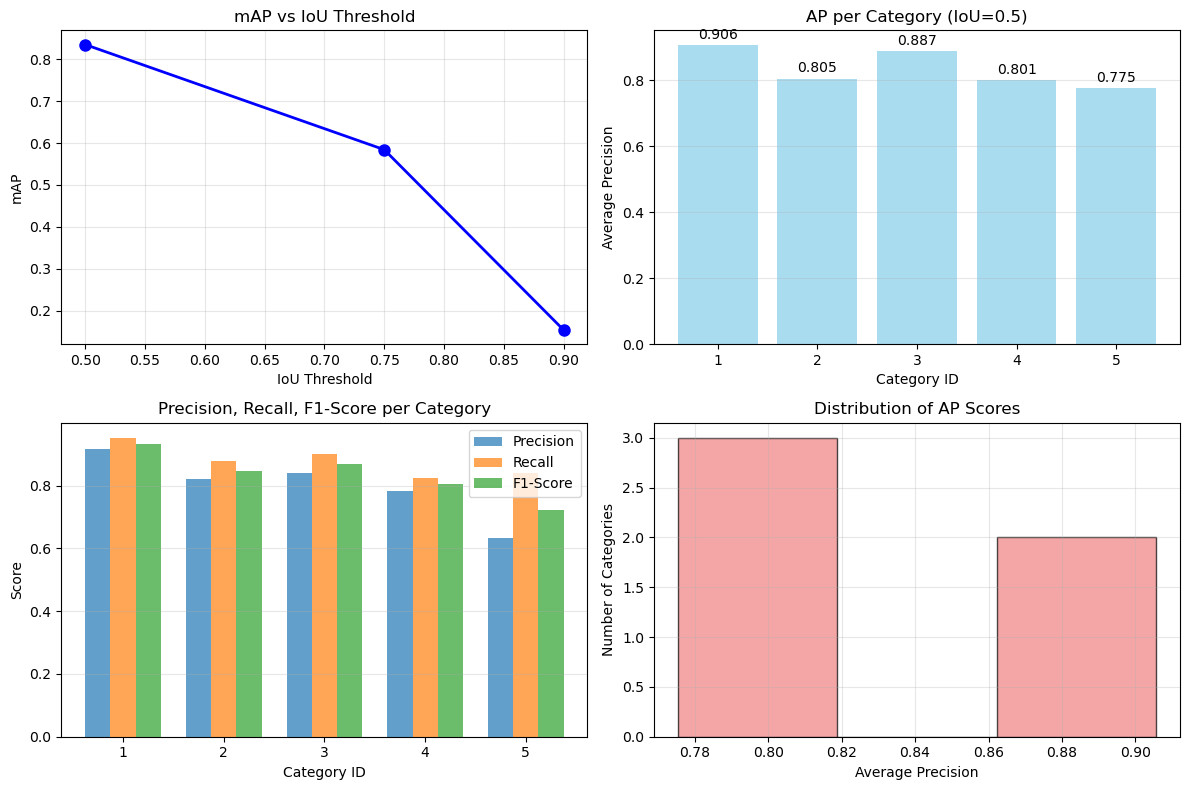

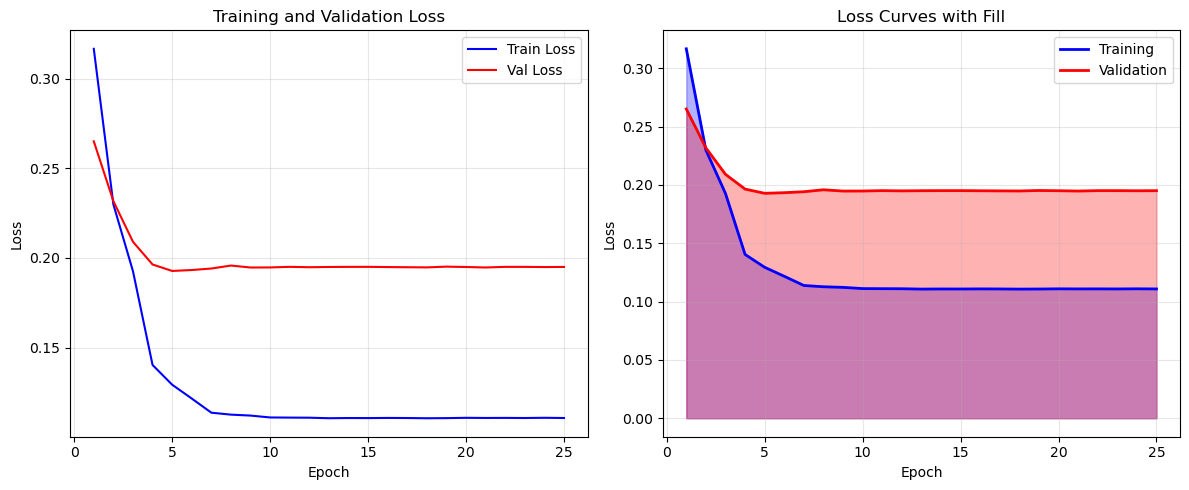


Visualizing predictions...


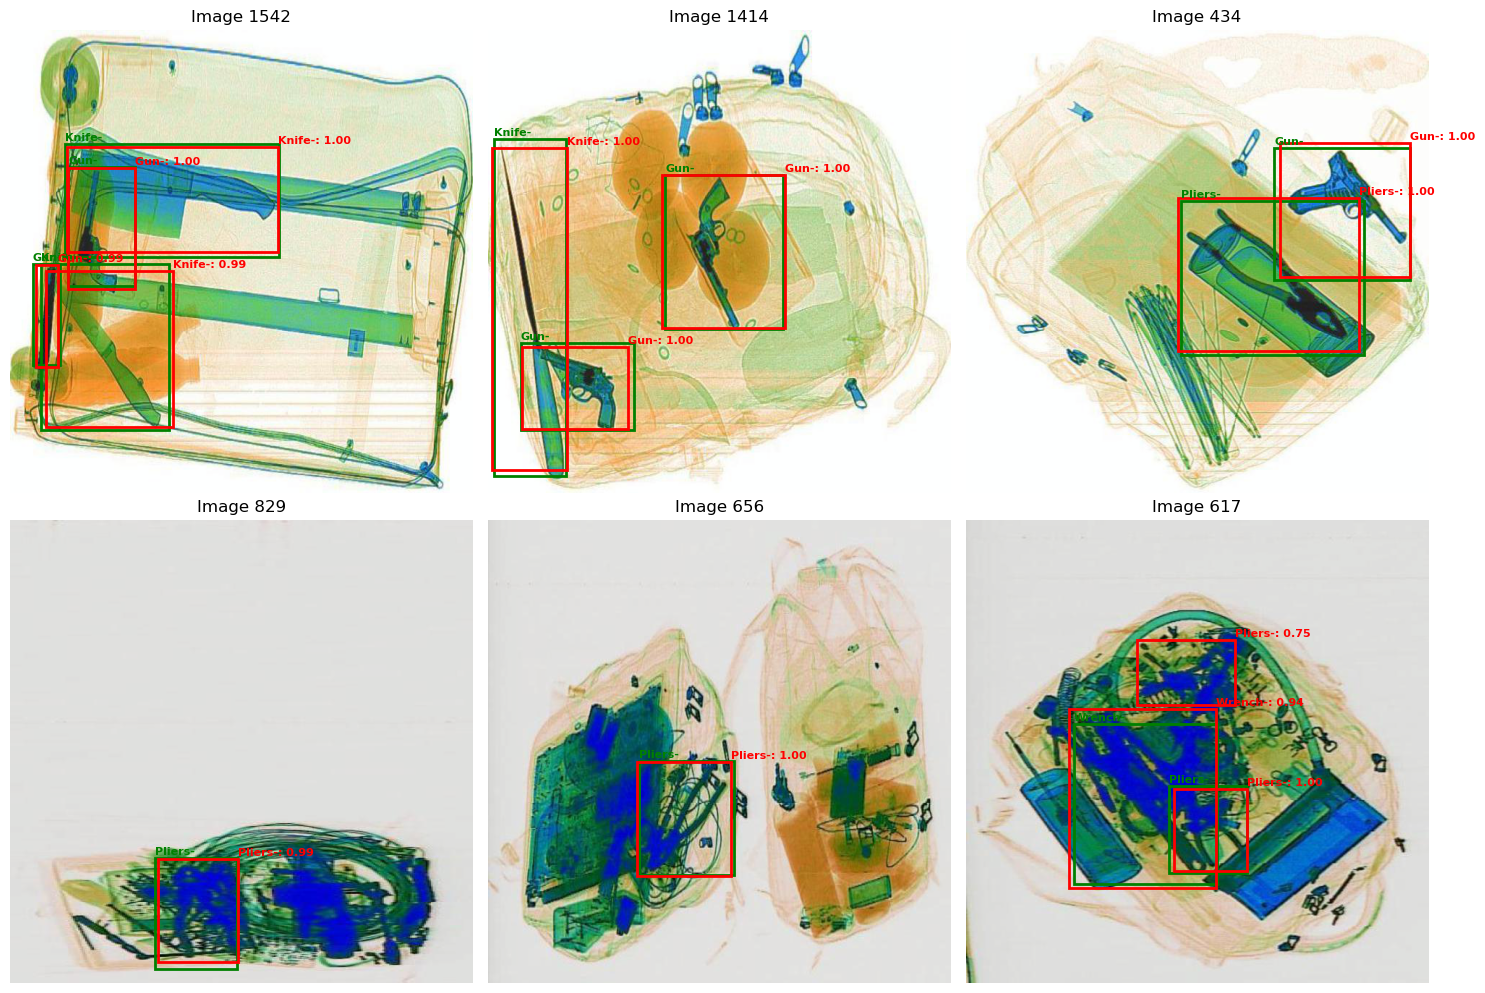


TRAINING COMPLETED
Best validation loss: 0.1928
Final mAP@0.5: 0.8347
Model saved as: best_sixray_model.pth


In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import json
import os
from PIL import Image
import numpy as np
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import cv2
from collections import defaultdict

class SIXrayDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transforms=None):
        """
        SIXray veri seti için özel Dataset sınıfı
        
        Args:
            root_dir (str): Görüntülerin bulunduğu ana dizin
            annotation_file (str): COCO formatında annotation dosyası
            transforms: Veri augmentasyonu için transformlar
        """
        self.root_dir = root_dir
        self.transforms = transforms
        
        # COCO annotation dosyasını yükle
        with open(annotation_file, 'r') as f:
            self.coco_data = json.load(f)
        
        # Kategorileri ve görüntüleri organize et
        self.images = self.coco_data['images']
        self.annotations = self.coco_data['annotations']
        self.categories = self.coco_data['categories']
        
        # Kategori ID'lerini isimlerle eşleştir
        self.category_id_to_name = {cat['id']: cat['name'] for cat in self.categories}
        self.category_name_to_id = {cat['name']: cat['id'] for cat in self.categories}
        
        # Görüntü ID'lerini annotation'larla eşleştir
        self.image_id_to_annotations = {}
        for ann in self.annotations:
            image_id = ann['image_id']
            if image_id not in self.image_id_to_annotations:
                self.image_id_to_annotations[image_id] = []
            self.image_id_to_annotations[image_id].append(ann)
        
        print(f"Veri seti yüklendi: {len(self.images)} görüntü, {len(self.annotations)} annotation")
        print(f"Kategoriler: {list(self.category_id_to_name.values())}")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Görüntü bilgilerini al
        img_info = self.images[idx]
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        
        # Görüntüyü yükle
        image = Image.open(img_path).convert("RGB")
        image_id = img_info['id']
        
        # Bu görüntüye ait annotation'ları al
        annotations = self.image_id_to_annotations.get(image_id, [])
        
        boxes = []
        labels = []
        areas = []
        iscrowd = []
        
        for ann in annotations:
            # COCO formatında bbox: [x, y, width, height]
            # PyTorch için [x1, y1, x2, y2] formatına çevir
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])
            areas.append(ann['area'])
            iscrowd.append(ann.get('iscrowd', 0))
        
        # Tensor'lara dönüştür
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        areas = torch.as_tensor(areas, dtype=torch.float32)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)
        
        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([image_id]),
            "area": areas,
            "iscrowd": iscrowd
        }
        
        if self.transforms:
            image = self.transforms(image)
        else:
            # Varsayılan transform
            transform = transforms.Compose([
                transforms.ToTensor()
            ])
            image = transform(image)
        
        return image, target

def get_model(num_classes):
    """
    Faster R-CNN modelini oluştur ve son katmanı özelleştir
    """
    # Pre-trained Faster R-CNN modelini yükle
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Classifier'ın input feature sayısını al
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Yeni classifier oluştur (num_classes + 1 background için)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes + 1)
    
    return model

def collate_fn(batch):
    """
    DataLoader için özel collate function
    """
    return tuple(zip(*batch))

def train_one_epoch(model, optimizer, data_loader, device, epoch):
    """
    Bir epoch için eğitim fonksiyonu
    """
    model.train()
    total_loss = 0
    num_batches = 0
    
    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
        num_batches += 1
        
        if i % 50 == 0:
            print(f'Epoch: {epoch}, Batch: {i}, Loss: {losses.item():.4f}')
    
    avg_loss = total_loss / num_batches
    print(f'Epoch {epoch} - Ortalama Loss: {avg_loss:.4f}')
    return avg_loss

def evaluate_model(model, data_loader, device):
    """
    Model değerlendirme fonksiyonu - sadece loss hesaplama
    """
    model.train()  # Training modunda bırak ki loss hesaplayabilelim
    total_loss = 0
    num_batches = 0
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Training modunda loss_dict döner
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            total_loss += losses.item()
            num_batches += 1
    
    avg_loss = total_loss / num_batches
    print(f'Validation Loss: {avg_loss:.4f}')
    return avg_loss

# ==================== OBJECT DETECTION METRICS ====================

def calculate_iou(box1, box2):
    """
    İki bbox arasındaki IoU hesapla
    box1, box2: [x1, y1, x2, y2] formatında
    """
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2
    
    # Intersection alanı
    x1_inter = max(x1_1, x1_2)
    y1_inter = max(y1_1, y1_2)
    x2_inter = min(x2_1, x2_2)
    y2_inter = min(y2_1, y2_2)
    
    if x2_inter <= x1_inter or y2_inter <= y1_inter:
        return 0.0
    
    inter_area = (x2_inter - x1_inter) * (y2_inter - y1_inter)
    
    # Union alanı
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    union_area = area1 + area2 - inter_area
    
    return inter_area / union_area if union_area > 0 else 0.0

def compute_ap(recall, precision):
    """
    Average Precision (AP) hesapla - 11-point interpolation
    """
    # Recall ve precision listelerini numpy array'e çevir
    recall = np.array(recall)
    precision = np.array(precision)
    
    if len(recall) == 0 or len(precision) == 0:
        return 0.0
    
    # Recall değerlerini sırala
    sorted_indices = np.argsort(recall)
    recall = recall[sorted_indices]
    precision = precision[sorted_indices]
    
    # 11-point interpolation için recall noktaları
    recall_points = np.linspace(0, 1, 11)
    interpolated_precisions = []
    
    for r in recall_points:
        # Bu recall değeri için maksimum precision'u bul
        precisions_at_recall = precision[recall >= r]
        if len(precisions_at_recall) > 0:
            interpolated_precisions.append(np.max(precisions_at_recall))
        else:
            interpolated_precisions.append(0.0)
    
    # AP = ortalama precision
    ap = np.mean(interpolated_precisions)
    return ap

def evaluate_detections(predictions, targets, iou_thresholds=[0.5], conf_threshold=0.5):
    """
    Object detection evaluation - IoU, mAP, precision, recall hesapla
    
    Args:
        predictions: List of prediction dictionaries
        targets: List of target dictionaries
        iou_thresholds: IoU threshold değerleri
        conf_threshold: Confidence threshold
    
    Returns:
        Dict containing evaluation metrics
    """
    
    # Kategorileri topla
    all_categories = set()
    for target in targets:
        all_categories.update(target['labels'].tolist())
    all_categories = sorted(list(all_categories))
    
    results = {}
    
    for iou_thresh in iou_thresholds:
        print(f"\nEvaluating at IoU threshold: {iou_thresh}")
        
        # Her kategori için ayrı değerlendirme
        category_aps = {}
        category_metrics = {}
        
        for category_id in all_categories:
            # Bu kategori için tüm prediction ve target'ları topla
            category_predictions = []
            category_targets = []
            
            for pred, target in zip(predictions, targets):
                # Predictions
                pred_boxes = pred['boxes']
                pred_labels = pred['labels']
                pred_scores = pred['scores']
                
                # Bu kategoriye ait tahminleri filtrele
                cat_mask = (pred_labels == category_id) & (pred_scores > conf_threshold)
                if cat_mask.sum() > 0:
                    category_predictions.extend([
                        {
                            'box': box,
                            'score': score,
                            'image_id': len(category_predictions) // 10  # Basit image_id
                        }
                        for box, score in zip(pred_boxes[cat_mask], pred_scores[cat_mask])
                    ])
                
                # Targets
                target_boxes = target['boxes']
                target_labels = target['labels']
                
                # Bu kategoriye ait ground truth'ları filtrele
                gt_mask = target_labels == category_id
                if gt_mask.sum() > 0:
                    category_targets.extend([
                        {
                            'box': box,
                            'image_id': len(category_targets) // 10  # Basit image_id
                        }
                        for box in target_boxes[gt_mask]
                    ])
            
            if len(category_predictions) == 0 or len(category_targets) == 0:
                category_aps[category_id] = 0.0
                category_metrics[category_id] = {
                    'precision': 0.0,
                    'recall': 0.0,
                    'f1': 0.0,
                    'tp': 0,
                    'fp': 0,
                    'fn': len(category_targets)
                }
                continue
            
            # Confidence'a göre sırala
            category_predictions.sort(key=lambda x: x['score'], reverse=True)
            
            # TP, FP hesapla
            tp = []
            fp = []
            gt_matched = set()
            
            for pred in category_predictions:
                pred_box = pred['box']
                best_iou = 0
                best_gt_idx = -1
                
                # Bu prediction için en iyi GT'yi bul
                for gt_idx, gt in enumerate(category_targets):
                    if gt_idx in gt_matched:
                        continue
                    
                    gt_box = gt['box']
                    iou = calculate_iou(pred_box, gt_box)
                    
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_idx = gt_idx
                
                # IoU threshold kontrolü
                if best_iou >= iou_thresh and best_gt_idx != -1:
                    tp.append(1)
                    fp.append(0)
                    gt_matched.add(best_gt_idx)
                else:
                    tp.append(0)
                    fp.append(1)
            
            # Kümülatif TP, FP
            tp_cumsum = np.cumsum(tp)
            fp_cumsum = np.cumsum(fp)
            
            # Precision ve Recall hesapla
            total_gt = len(category_targets)
            precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-10)
            recalls = tp_cumsum / (total_gt + 1e-10)
            
            # AP hesapla
            ap = compute_ap(recalls, precisions)
            category_aps[category_id] = ap
            
            # Final metrics
            final_tp = tp_cumsum[-1] if len(tp_cumsum) > 0 else 0
            final_fp = fp_cumsum[-1] if len(fp_cumsum) > 0 else 0
            final_fn = total_gt - final_tp
            
            final_precision = final_tp / (final_tp + final_fp) if (final_tp + final_fp) > 0 else 0
            final_recall = final_tp / (final_tp + final_fn) if (final_tp + final_fn) > 0 else 0
            final_f1 = 2 * (final_precision * final_recall) / (final_precision + final_recall) if (final_precision + final_recall) > 0 else 0
            
            category_metrics[category_id] = {
                'precision': final_precision,
                'recall': final_recall,
                'f1': final_f1,
                'tp': int(final_tp),
                'fp': int(final_fp),
                'fn': int(final_fn),
                'ap': ap
            }
            
            print(f"Category {category_id}: AP={ap:.4f}, P={final_precision:.4f}, R={final_recall:.4f}, F1={final_f1:.4f}")
        
        # mAP hesapla
        map_score = np.mean(list(category_aps.values())) if category_aps else 0.0
        
        results[f'IoU_{iou_thresh}'] = {
            'mAP': map_score,
            'category_aps': category_aps,
            'category_metrics': category_metrics
        }
        
        print(f"mAP@{iou_thresh}: {map_score:.4f}")
    
    return results

def evaluate_model_with_detection_metrics(model, data_loader, device, 
                                        iou_thresholds=[0.5, 0.75], 
                                        conf_threshold=0.5):
    """
    Model'i object detection metrikleri ile değerlendir
    """
    model.eval()
    
    all_predictions = []
    all_targets = []
    
    print("Predictions yapılıyor...")
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(data_loader):
            if batch_idx % 10 == 0:
                print(f"Batch {batch_idx}/{len(data_loader)}")
                
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Predictions al
            predictions = model(images)
            
            for pred, target in zip(predictions, targets):
                all_predictions.append({
                    'boxes': pred['boxes'].cpu(),
                    'labels': pred['labels'].cpu(),
                    'scores': pred['scores'].cpu()
                })
                
                all_targets.append({
                    'boxes': target['boxes'].cpu(),
                    'labels': target['labels'].cpu()
                })
    
    print(f"Toplam {len(all_predictions)} prediction yapıldı.")
    
    # Evaluation yap
    results = evaluate_detections(all_predictions, all_targets, 
                                iou_thresholds, conf_threshold)
    
    return results

def print_detailed_results(results, category_names=None):
    """
    Detaylı sonuçları yazdır
    """
    if category_names is None:
        category_names = {1: 'gun', 2: 'knife', 3: 'wrench', 
                         4: 'pliers', 5: 'scissors', 6: 'hammer'}
    
    print("\n" + "="*80)
    print("DETAILED EVALUATION RESULTS")
    print("="*80)
    
    for iou_key, iou_results in results.items():
        iou_thresh = float(iou_key.split('_')[1])
        print(f"\nIoU Threshold: {iou_thresh}")
        print("-" * 50)
        print(f"Overall mAP: {iou_results['mAP']:.4f}")
        print("\nPer-category results:")
        
        print(f"{'Category':<12} {'AP':<8} {'Precision':<10} {'Recall':<8} {'F1':<8} {'TP':<4} {'FP':<4} {'FN':<4}")
        print("-" * 70)
        
        for cat_id, metrics in iou_results['category_metrics'].items():
            cat_name = category_names.get(cat_id, f'class_{cat_id}')
            ap = iou_results['category_aps'][cat_id]
            
            print(f"{cat_name:<12} {ap:<8.4f} {metrics['precision']:<10.4f} "
                  f"{metrics['recall']:<8.4f} {metrics['f1']:<8.4f} "
                  f"{metrics['tp']:<4} {metrics['fp']:<4} {metrics['fn']:<4}")

def visualize_metrics_comparison(results):
    """
    Farklı IoU threshold'ları için metrikleri görselleştir
    """
    iou_thresholds = []
    map_scores = []
    
    for key, value in results.items():
        if key.startswith('IoU_'):
            iou_thresh = float(key.split('_')[1])
            iou_thresholds.append(iou_thresh)
            map_scores.append(value['mAP'])
    
    if len(iou_thresholds) == 0:
        print("Görselleştirilecek sonuç bulunamadı.")
        return
    
    # mAP vs IoU threshold grafiği
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(iou_thresholds, map_scores, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('IoU Threshold')
    plt.ylabel('mAP')
    plt.title('mAP vs IoU Threshold')
    plt.grid(True, alpha=0.3)
    
    # İlk IoU threshold için kategori bazlı AP'ler
    if len(results) > 0:
        first_result = list(results.values())[0]
        categories = list(first_result['category_aps'].keys())
        aps = list(first_result['category_aps'].values())
        
        plt.subplot(2, 2, 2)
        bars = plt.bar(range(len(categories)), aps, color='skyblue', alpha=0.7)
        plt.xlabel('Category ID')
        plt.ylabel('Average Precision')
        plt.title(f'AP per Category (IoU={iou_thresholds[0]})')
        plt.xticks(range(len(categories)), categories)
        plt.grid(True, alpha=0.3, axis='y')
        
        # Bar değerlerini göster
        for bar, ap in zip(bars, aps):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{ap:.3f}', ha='center', va='bottom', fontsize=10)
        
        # Precision, Recall, F1 için kategori bazlı karşılaştırma
        precisions = [first_result['category_metrics'][cat]['precision'] for cat in categories]
        recalls = [first_result['category_metrics'][cat]['recall'] for cat in categories]
        f1_scores = [first_result['category_metrics'][cat]['f1'] for cat in categories]
        
        plt.subplot(2, 2, 3)
        x = np.arange(len(categories))
        width = 0.25
        
        plt.bar(x - width, precisions, width, label='Precision', alpha=0.7)
        plt.bar(x, recalls, width, label='Recall', alpha=0.7)
        plt.bar(x + width, f1_scores, width, label='F1-Score', alpha=0.7)
        
        plt.xlabel('Category ID')
        plt.ylabel('Score')
        plt.title('Precision, Recall, F1-Score per Category')
        plt.xticks(x, categories)
        plt.legend()
        plt.grid(True, alpha=0.3, axis='y')
        
        # mAP dağılımı
        plt.subplot(2, 2, 4)
        plt.hist(aps, bins=max(3, len(aps)//2), alpha=0.7, color='lightcoral', edgecolor='black')
        plt.xlabel('Average Precision')
        plt.ylabel('Number of Categories')
        plt.title('Distribution of AP Scores')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def evaluate_model_with_metrics(model, data_loader, device, iou_thresholds=[0.5, 0.75]):
    """
    Model değerlendirme fonksiyonu - Object detection metrikleri ile
    """
    print("Object detection evaluation başlıyor...")
    
    results = evaluate_model_with_detection_metrics(
        model, data_loader, device, iou_thresholds
    )
    
    # Sonuçları yazdır
    print_detailed_results(results)
    
    # Görselleştir
    visualize_metrics_comparison(results)
    
    # mAP@0.5 değerini döndür (backward compatibility için)
    map_05 = results.get('IoU_0.5', {}).get('mAP', 0.0)
    
    return map_05, results

# ==================== VISUALIZATION ====================

def visualize_predictions(model, dataset, device, num_images=6):
    """
    Model tahminlerini görselleştir
    """
    model.eval()
    
    # Kategori isimlerini al
    category_names = {v: k for k, v in dataset.category_name_to_id.items()}
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i in range(min(num_images, len(axes))):
        # Rastgele bir görüntü seç
        idx = np.random.randint(0, len(dataset))
        image, target = dataset[idx]
        
        # Tahmin yap
        with torch.no_grad():
            prediction = model([image.to(device)])
        
        # Görüntüyü numpy array'e çevir
        img_np = image.permute(1, 2, 0).cpu().numpy()
        
        # Normalizasyonu geri al (eğer varsa)
        if img_np.min() < 0:  # Normalize edilmiş görüntü
            img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_np = np.clip(img_np, 0, 1)
        
        # Görüntüyü çiz
        axes[i].imshow(img_np)
        axes[i].set_title(f'Image {idx}')
        axes[i].axis('off')
        
        # Gerçek bbox'ları çiz (yeşil)
        for j, box in enumerate(target['boxes']):
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            rect = plt.Rectangle((x1, y1), width, height, 
                               linewidth=2, edgecolor='green', facecolor='none')
            axes[i].add_patch(rect)
            
            # Label'ı yaz
            label_id = target['labels'][j].item()
            if label_id in category_names:
                axes[i].text(x1, y1-5, category_names[label_id], 
                           color='green', fontsize=8, weight='bold')
        
        # Tahmin edilen bbox'ları çiz (kırmızı)
        pred_boxes = prediction[0]['boxes'].cpu()
        pred_labels = prediction[0]['labels'].cpu()
        pred_scores = prediction[0]['scores'].cpu()
        
        # Sadece yüksek confidence'lı tahminleri göster
        high_conf_mask = pred_scores > 0.5
        pred_boxes = pred_boxes[high_conf_mask]
        pred_labels = pred_labels[high_conf_mask]
        pred_scores = pred_scores[high_conf_mask]
        
        for j, box in enumerate(pred_boxes):
            x1, y1, x2, y2 = box
            width = x2 - x1
            height = y2 - y1
            rect = plt.Rectangle((x1, y1), width, height, 
                               linewidth=2, edgecolor='red', facecolor='none')
            axes[i].add_patch(rect)
            
            # Prediction label ve score'u yaz
            label_id = pred_labels[j].item()
            score = pred_scores[j].item()
            if label_id in category_names:
                axes[i].text(x2, y1-5, f'{category_names[label_id]}: {score:.2f}', 
                           color='red', fontsize=8, weight='bold')
    
    plt.tight_layout()
    plt.show()

def inference_single_image(model_path, image_path, device):
    """
    Tek bir görüntü üzerinde inference yap
    """
    # Model yükle
    model = get_model(6)  # 6 sınıf
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    
    # Görüntü yükle ve preprocess et
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Tahmin yap
    with torch.no_grad():
        prediction = model(image_tensor)[0]
    
    # Sonuçları işle
    boxes = prediction['boxes'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    
    # Kategori isimleri
    category_names = {1: 'gun', 2: 'knife', 3: 'wrench', 
                     4: 'pliers', 5: 'scissors', 6: 'hammer'}
    
    # Yüksek confidence'lı tahminleri filtrele
    high_conf_mask = scores > 0.5
    boxes = boxes[high_conf_mask]
    labels = labels[high_conf_mask]
    scores = scores[high_conf_mask]
    
    # Sonuçları yazdır
    print(f"Detected objects in {image_path}:")
    for i, (box, label, score) in enumerate(zip(boxes, labels, scores)):
        x1, y1, x2, y2 = box
        class_name = category_names.get(label, f'class_{label}')
        print(f"  {i+1}. {class_name}: {score:.3f} at [{x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f}]")
    
    return boxes, labels, scores

# ==================== MAIN TRAINING FUNCTION ====================

def main():
    # Hyperparameters
    BATCH_SIZE = 4
    NUM_EPOCHS = 25
    LEARNING_RATE = 0.005
    STEP_SIZE = 3
    GAMMA = 0.1
    
    # Device setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    
    # Data paths - Bu yolları kendi veri setinize göre güncelleyin
    TRAIN_ROOT = '/home/svg/Masaüstü/CV_PROJE_HAZIRAN_2025/sixray_yolov8.v964i.coco/train/'
    TRAIN_ANNOTATION = '/home/svg/Masaüstü/CV_PROJE_HAZIRAN_2025/sixray_yolov8.v964i.coco/train/_annotations.coco.json'
    VAL_ROOT = '/home/svg/Masaüstü/CV_PROJE_HAZIRAN_2025/sixray_yolov8.v964i.coco/valid'
    VAL_ANNOTATION = '/home/svg/Masaüstü/CV_PROJE_HAZIRAN_2025/sixray_yolov8.v964i.coco/valid/_annotations.coco.json'
    
    # Data transforms
    train_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    val_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Datasets
    print("Loading datasets...")
    train_dataset = SIXrayDataset(TRAIN_ROOT, TRAIN_ANNOTATION, train_transforms)
    val_dataset = SIXrayDataset(VAL_ROOT, VAL_ANNOTATION, val_transforms)
    
    # Data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        collate_fn=collate_fn,
        num_workers=4
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        collate_fn=collate_fn,
        num_workers=4
    )
    
    # Model
    num_classes = len(train_dataset.category_id_to_name)
    model = get_model(num_classes)
    model.to(device)
    
    # Optimizer and scheduler
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, 
                         momentum=0.9, weight_decay=0.0005)
    scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
    
    # Training history
    train_losses = []
    val_losses = []
    
    print(f"Starting training for {NUM_EPOCHS} epochs...")
    print(f"Train samples: {len(train_dataset)}")
    print(f"Val samples: {len(val_dataset)}")
    print(f"Batch size: {BATCH_SIZE}")
    print(f"Number of classes: {num_classes}")
    print("-" * 50)
    
    best_val_loss = float('inf')
    
    # Training loop
    for epoch in range(NUM_EPOCHS):
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
        
        # Train
        train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch+1)
        train_losses.append(train_loss)
        
        # Validation
        val_loss = evaluate_model(model, val_loader, device)
        val_losses.append(val_loss)
        
        # Learning rate scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Learning rate: {current_lr:.6f}')
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_sixray_model.pth')
            print(f'New best model saved! Val Loss: {val_loss:.4f}')
        
        print("-" * 50)
    
    # Final evaluation with object detection metrics
    print("\nFinal evaluation with object detection metrics...")
    final_map, detailed_results = evaluate_model_with_metrics(
        model, val_loader, device, iou_thresholds=[0.5, 0.75, 0.9]
    )
    
    # Training history visualization
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, NUM_EPOCHS+1), train_losses, 'b-', label='Train Loss')
    plt.plot(range(1, NUM_EPOCHS+1), val_losses, 'r-', label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    epochs = range(1, NUM_EPOCHS+1)
    plt.plot(epochs, train_losses, 'b-', linewidth=2, label='Training')
    plt.plot(epochs, val_losses, 'r-', linewidth=2, label='Validation')
    plt.fill_between(epochs, train_losses, alpha=0.3, color='blue')
    plt.fill_between(epochs, val_losses, alpha=0.3, color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves with Fill')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Visualize some predictions
    print("\nVisualizing predictions...")
    visualize_predictions(model, val_dataset, device, num_images=6)
    
    # Final results summary
    print("\n" + "="*80)
    print("TRAINING COMPLETED")
    print("="*80)
    print(f"Best validation loss: {best_val_loss:.4f}")
    print(f"Final mAP@0.5: {final_map:.4f}")
    print(f"Model saved as: best_sixray_model.pth")
    print("="*80)
    
    return model, train_losses, val_losses, detailed_results

if __name__ == "__main__":
    main()

### predict

Test annotation dosyası: /home/svg/Masaüstü/CV_PROJE_HAZIRAN_2025/sixray_yolov8.v964i.coco/test/_annotations.coco.json
Test görüntüleri klasörü: /home/svg/Masaüstü/CV_PROJE_HAZIRAN_2025/sixray_yolov8.v964i.coco/test
Device: cuda
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Dataset sınıfları: ['dangerous_goods', 'Gun-', 'Knife-', 'Pliers-', 'Scissors-', 'Wrench-']
Category ID to Name mapping: {0: 'dangerous_goods', 1: 'Gun-', 2: 'Knife-', 3: 'Pliers-', 4: 'Scissors-', 5: 'Wrench-'}
Test seti boyutu: 829
Toplam sınıf sayısı: 7
Model yükleniyor...


/home/svg/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/svg/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_7069/3976174508.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This

Model değerlendiriliyor...
Basit sınıf bazlı değerlendirme yapılıyor...

=== BASİT SINIF BAZLI DEĞERLENDİRME (Confidence > 0.5) ===
Toplam test görüntüsü: 829
Sınıf                GT Sayısı    Toplam Pred     Yüksek Conf     Ortalama Conf   Detection Rate 
----------------------------------------------------------------------------------------------------
Gun-                 474          209             135             0.637           0.285          
Knife-               169          945             296             0.368           1.000          
Pliers-              524          103             44              0.466           0.084          
Scissors-            120          193             28              0.246           0.233          
Wrench-              306          100             19              0.310           0.062          
----------------------------------------------------------------------------------------------------
TOPLAM               1593         1550            5

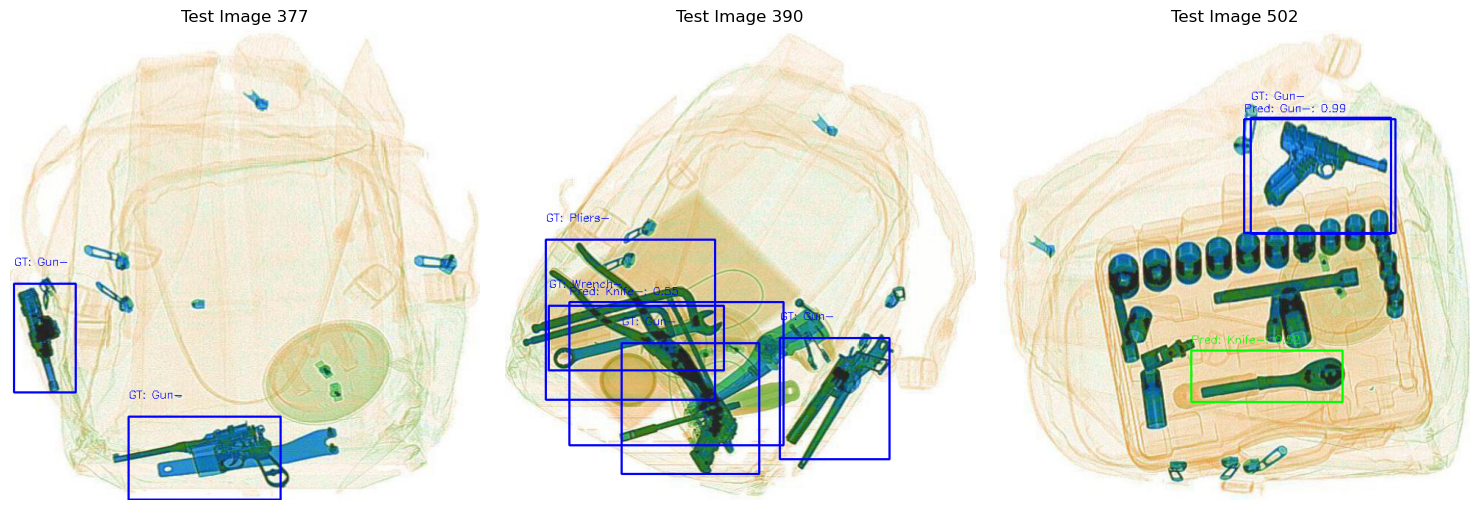

In [2]:
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import json
import os
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import argparse
from collections import defaultdict

class SixRayDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, annotation_file, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.coco = COCO(annotation_file)
        self.ids = list(sorted(self.coco.imgs.keys()))
        
        # SixRay sınıflarını tanımla (COCO formatında category_id'lere göre)
        self.categories = self.coco.loadCats(self.coco.getCatIds())
        self.category_names = [cat['name'] for cat in self.categories]
        self.category_id_to_name = {cat['id']: cat['name'] for cat in self.categories}
        print(f"Dataset sınıfları: {self.category_names}")
        print(f"Category ID to Name mapping: {self.category_id_to_name}")
        
    def __getitem__(self, idx):
        # COCO annotation'dan görüntü bilgilerini al
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        
        # Görüntüyü yükle
        img = Image.open(img_path).convert("RGB")
        
        # Bu görüntü için annotation'ları al
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        
        # Bounding box'ları ve etiketleri hazırla
        boxes = []
        labels = []
        
        for ann in anns:
            x, y, w, h = ann['bbox']
            # COCO formatı [x, y, width, height] -> PyTorch formatı [x1, y1, x2, y2]
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])
        
        if len(boxes) == 0:
            # Eğer annotation yoksa boş tensor'lar oluştur
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = torch.tensor([img_id])
        
        if self.transforms is not None:
            img = self.transforms(img)
            
        return img, target
    
    def __len__(self):
        return len(self.ids)

def get_model(num_classes, model_path):
    """Pre-trained Faster R-CNN modelini yükle"""
    model = fasterrcnn_resnet50_fpn(pretrained=False)
    
    # Classifier'ı yeni sınıf sayısına göre değiştir
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features, num_classes
    )
    
    # Eğitilmiş ağırlıkları yükle
    checkpoint = torch.load(model_path, map_location='cpu')
    if 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    
    return model

def collate_fn(batch):
    """DataLoader için custom collate function"""
    return tuple(zip(*batch))

def simple_class_evaluation(model, data_loader, device, category_id_to_name, confidence_threshold=0.5):
    """Basit sınıf bazlı değerlendirme - COCO evaluation olmadan"""
    model.eval()
    
    # Sınıf bazlı istatistikler
    class_stats = defaultdict(lambda: {
        'total_predictions': 0, 
        'total_gt': 0,
        'high_conf_predictions': 0,
        'predictions_by_conf': []
    })
    
    total_images = 0
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            predictions = model(images)
            
            total_images += len(images)
            
            for i, pred in enumerate(predictions):
                # Ground truth sayıları
                gt_labels = targets[i]['labels'].cpu().numpy()
                for gt_label in gt_labels:
                    class_stats[gt_label]['total_gt'] += 1
                
                # Prediction sayıları ve confidence'ları
                pred_labels = pred['labels'].cpu().numpy()
                pred_scores = pred['scores'].cpu().numpy()
                
                for label, score in zip(pred_labels, pred_scores):
                    class_stats[label]['total_predictions'] += 1
                    class_stats[label]['predictions_by_conf'].append(score)
                    
                    if score > confidence_threshold:
                        class_stats[label]['high_conf_predictions'] += 1
    
    # Sonuçları yazdır
    print(f"\n=== BASİT SINIF BAZLI DEĞERLENDİRME (Confidence > {confidence_threshold}) ===")
    print(f"Toplam test görüntüsü: {total_images}")
    print(f"{'Sınıf':<20} {'GT Sayısı':<12} {'Toplam Pred':<15} {'Yüksek Conf':<15} {'Ortalama Conf':<15} {'Detection Rate':<15}")
    print("-" * 100)
    
    total_gt = 0
    total_pred = 0
    total_high_conf = 0
    
    for cat_id in sorted(category_id_to_name.keys()):
        if cat_id in class_stats:
            cat_name = category_id_to_name[cat_id]
            gt_count = class_stats[cat_id]['total_gt']
            pred_count = class_stats[cat_id]['total_predictions']
            high_conf_count = class_stats[cat_id]['high_conf_predictions']
            
            # Ortalama confidence hesapla
            conf_scores = class_stats[cat_id]['predictions_by_conf']
            avg_conf = np.mean(conf_scores) if conf_scores else 0.0
            
            # Detection rate (basit bir metrik)
            detection_rate = min(high_conf_count / max(gt_count, 1), 1.0) if gt_count > 0 else 0.0
            
            print(f"{cat_name:<20} {gt_count:<12} {pred_count:<15} {high_conf_count:<15} {avg_conf:<15.3f} {detection_rate:<15.3f}")
            
            total_gt += gt_count
            total_pred += pred_count
            total_high_conf += high_conf_count
    
    print("-" * 100)
    print(f"{'TOPLAM':<20} {total_gt:<12} {total_pred:<15} {total_high_conf:<15}")
    
    return class_stats
    """Modeli değerlendir ve sınıf bazlı COCO metriklerini hesapla"""
    model.eval()
    coco_results = []
    
    # Sınıf bazlı istatistikler için
    class_stats = defaultdict(lambda: {'tp': 0, 'fp': 0, 'fn': 0, 'total_gt': 0, 'total_pred': 0})
    
    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            
            # Model predictions
            predictions = model(images)
            
            # Sonuçları COCO formatına çevir
            for i, pred in enumerate(predictions):
                image_id = targets[i]['image_id'].item()
                boxes = pred['boxes'].cpu().numpy()
                scores = pred['scores'].cpu().numpy()
                labels = pred['labels'].cpu().numpy()
                
                # Ground truth için sınıf sayısını say
                gt_labels = targets[i]['labels'].cpu().numpy()
                for gt_label in gt_labels:
                    class_stats[gt_label]['total_gt'] += 1
                
                for j in range(len(boxes)):
                    if scores[j] > 0.05:  # Minimum confidence threshold
                        x1, y1, x2, y2 = boxes[j]
                        coco_results.append({
                            'image_id': image_id,
                            'category_id': int(labels[j]),
                            'bbox': [float(x1), float(y1), float(x2-x1), float(y2-y1)],
                            'score': float(scores[j])
                        })
                        
                        # Prediction sayısını artır
                        class_stats[labels[j]]['total_pred'] += 1
    
    if len(coco_results) == 0:
        print("Hiç detection sonucu bulunamadı!")
        return None, class_stats
    
    # COCO evaluation - Genel
    coco_dt = coco_gt.loadRes(coco_results)
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    
    # Sınıf bazlı değerlendirme
    print("\n=== SINIF BAZLI PERFORMANS ===")
    print(f"{'Sınıf':<15} {'mAP@0.5':<10} {'mAP@0.75':<10} {'mAP@0.5:0.95':<12} {'GT Count':<10} {'Pred Count':<12}")
    print("-" * 80)
    
    # Her sınıf için ayrı ayrı değerlendirme yap
    for cat_id in sorted(category_id_to_name.keys()):
        cat_name = category_id_to_name[cat_id]
        
        try:
            # Bu sınıf için COCO evaluation
            coco_eval_class = COCOeval(coco_gt, coco_dt, 'bbox')
            coco_eval_class.params.catIds = [cat_id]
            coco_eval_class.evaluate()
            coco_eval_class.accumulate()
            
            # Metrikleri al - Güvenli şekilde
            stats = coco_eval_class.stats
            if len(stats) >= 3 and stats is not None:
                map_50_95 = stats[0] if not np.isnan(stats[0]) else 0.0
                map_50 = stats[1] if not np.isnan(stats[1]) else 0.0
                map_75 = stats[2] if not np.isnan(stats[2]) else 0.0
            else:
                map_50_95 = map_50 = map_75 = 0.0
                
        except Exception as e:
            print(f"Sınıf {cat_name} için değerlendirme hatası: {e}")
            map_50_95 = map_50 = map_75 = 0.0
        
        gt_count = class_stats[cat_id]['total_gt']
        pred_count = class_stats[cat_id]['total_pred']
        
        print(f"{cat_name:<15} {map_50:<10.3f} {map_75:<10.3f} {map_50_95:<12.3f} {gt_count:<10} {pred_count:<12}")
    
    return coco_eval.stats, class_stats

def visualize_predictions_fixed(model, dataset, device, num_images=5):
    """Düzeltilmiş görselleştirme fonksiyonu"""
    model.eval()
    
    # Rastgele birkaç görüntü seç
    indices = np.random.choice(len(dataset), min(num_images, len(dataset)), replace=False)
    
    fig, axes = plt.subplots(1, len(indices), figsize=(15, 5))
    if len(indices) == 1:
        axes = [axes]
    
    # Renk paleti (sınıflar için)
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)]
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            img, target = dataset[idx]
            img_tensor = img.unsqueeze(0).to(device)
            
            # Prediction
            pred = model(img_tensor)[0]
            
            # Görüntüyü numpy array'e çevir - DÜZELTİLMİŞ VERSİYON
            img_np = img.permute(1, 2, 0).cpu().numpy()
            
            # Görüntüyü [0, 1] aralığından [0, 255] aralığına çevir
            if img_np.max() <= 1.0:
                img_np = (img_np * 255).astype(np.uint8)
            else:
                img_np = img_np.astype(np.uint8)
            
            # RGB'den BGR'ye çevir (OpenCV için)
            img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
            
            # Ground truth box'ları çiz (mavi)
            for box, label in zip(target['boxes'], target['labels']):
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(img_bgr, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Mavi
                class_name = dataset.category_id_to_name.get(label.item(), f'Class_{label.item()}')
                cv2.putText(img_bgr, f'GT: {class_name}', 
                          (x1, y1-25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
            
            # Prediction'ları çiz (confidence > 0.5)
            for j, (box, score, label) in enumerate(zip(pred['boxes'], pred['scores'], pred['labels'])):
                if score > 0.5:
                    x1, y1, x2, y2 = map(int, box.cpu().numpy())
                    color = colors[j % len(colors)]
                    cv2.rectangle(img_bgr, (x1, y1), (x2, y2), color, 2)
                    
                    # Sınıf ismini göster
                    class_name = dataset.category_id_to_name.get(label.cpu().item(), f'Class_{label.cpu().item()}')
                    cv2.putText(img_bgr, f'Pred: {class_name}: {score:.2f}', 
                              (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
            
            # BGR'den RGB'ye geri çevir (matplotlib için)
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            
            axes[i].imshow(img_rgb)
            axes[i].axis('off')
            axes[i].set_title(f'Test Image {idx}')
    
    plt.tight_layout()
    plt.show()

def print_detailed_class_summary(class_stats, category_id_to_name):
    """Sınıf bazlı detaylı özet yazdır"""
    print("\n=== DETAYLI SINIF ÖZETİ ===")
    print(f"{'Sınıf':<20} {'GT Sayısı':<12} {'Pred Sayısı':<15} {'Recall Tahmini':<15}")
    print("-" * 65)
    
    total_gt = 0
    total_pred = 0
    
    for cat_id in sorted(category_id_to_name.keys()):
        cat_name = category_id_to_name[cat_id]
        gt_count = class_stats[cat_id]['total_gt']
        pred_count = class_stats[cat_id]['total_pred']
        
        # Basit recall tahmini (gerçek IoU hesabı olmadan)
        recall_estimate = min(pred_count / max(gt_count, 1), 1.0) if gt_count > 0 else 0.0
        
        print(f"{cat_name:<20} {gt_count:<12} {pred_count:<15} {recall_estimate:<15.3f}")
        
        total_gt += gt_count
        total_pred += pred_count
    
    print("-" * 65)
    print(f"{'TOPLAM':<20} {total_gt:<12} {total_pred:<15}")

def main():
    # Parametreler
    dataset_root = "/home/svg/Masaüstü/CV_PROJE_HAZIRAN_2025/sixray_yolov8.v964i.coco"
    model_path = "best_sixray_model.pth"
    test_annotation_file="/home/svg/Masaüstü/CV_PROJE_HAZIRAN_2025/sixray_yolov8.v964i.coco/test/_annotations.coco.json"
    
    # Test seti annotation dosyasını bul
    if not os.path.exists(test_annotation_file):
        print(f"Test annotation dosyası bulunamadı: {test_annotation_file}")
        for file in os.listdir(dataset_root):
            if 'test' in file.lower() and file.endswith('.json'):
                test_annotation_file = os.path.join(dataset_root, file)
                break
    
    if not os.path.exists(test_annotation_file):
        print("Test annotation dosyası bulunamadı. Mevcut dosyalar:")
        print(os.listdir(dataset_root))
        return
    
    print(f"Test annotation dosyası: {test_annotation_file}")
    
    # Test görüntülerinin klasörünü bul
    test_images_dir = None
    for item in os.listdir(dataset_root):
        item_path = os.path.join(dataset_root, item)
        if os.path.isdir(item_path) and 'test' in item.lower():
            test_images_dir = item_path
            break
    
    if test_images_dir is None:
        # Eğer test klasörü yoksa, genel images klasörünü kullan
        for item in ['images', 'test', 'valid']:
            item_path = os.path.join(dataset_root, item)
            if os.path.isdir(item_path):
                test_images_dir = item_path
                break
    
    print(f"Test görüntüleri klasörü: {test_images_dir}")
    
    # Device ayarla
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(f"Device: {device}")
    
    # Transform'lar
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    # Dataset oluştur
    test_dataset = SixRayDataset(
        root_dir=test_images_dir,
        annotation_file=test_annotation_file,
        transforms=transform
    )
    
    print(f"Test seti boyutu: {len(test_dataset)}")
    
    # DataLoader
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=2,
        shuffle=False,
        collate_fn=collate_fn
    )
    
    # Sınıf sayısını belirle (background + gerçek sınıflar)
    num_classes = len(test_dataset.categories) + 1
    print(f"Toplam sınıf sayısı: {num_classes}")
    
    # Modeli yükle
    print("Model yükleniyor...")
    model = get_model(num_classes, model_path)
    model.to(device)
    
    # Model'i değerlendir - İki farklı yöntem
    print("Model değerlendiriliyor...")
    coco_gt = test_dataset.coco
    
    # 1. Basit değerlendirme (daha güvenilir)
    print("Basit sınıf bazlı değerlendirme yapılıyor...")
    simple_stats = simple_class_evaluation(model, test_loader, device, test_dataset.category_id_to_name)
    
    # 2. COCO evaluation (detaylı ama bazen hata verebilir)
    print("\nCOCO evaluation yapılıyor...")
    try:
        eval_stats, class_stats = evaluate_model_per_class(model, test_loader, device, coco_gt, test_dataset.category_id_to_name)
        
        if eval_stats is not None:
            print("\n=== GENEL COCO EVALUATION SONUÇLARI ===")
            print(f"mAP (IoU=0.5:0.95): {eval_stats[0]:.4f}")
            print(f"mAP (IoU=0.5): {eval_stats[1]:.4f}")
            print(f"mAP (IoU=0.75): {eval_stats[2]:.4f}")
        
        # Detaylı sınıf özeti
        print_detailed_class_summary(class_stats, test_dataset.category_id_to_name)
        
    except Exception as e:
        print(f"COCO evaluation hatası: {e}")
        print("Sadece basit değerlendirme sonuçları kullanılacak.")
    
    # Bazı sonuçları görselleştir - Düzeltilmiş versiyon
    print("Sonuçlar görselleştiriliyor...")
    visualize_predictions_fixed(model, test_dataset, device, num_images=3)

if __name__ == "__main__":
    main()

In [ ]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter, defaultdict

def load_coco_annotations(annotation_file):
    """COCO formatındaki annotation dosyasını yükle"""
    with open(annotation_file, 'r') as f:
        coco_data = json.load(f)
    return coco_data

def analyze_class_distribution(coco_data):
    """Sınıf dağılımını analiz et"""
    
    # Kategori ID'lerini isimlerle eşleştir
    categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
    
    # Annotation'lardaki sınıf sayılarını say
    class_counts = Counter()
    image_class_counts = defaultdict(set)  # Her görüntüdeki farklı sınıfları takip et
    
    for ann in coco_data['annotations']:
        category_id = ann['category_id']
        class_name = categories[category_id]
        class_counts[class_name] += 1
        image_class_counts[ann['image_id']].add(class_name)
    
    # Görüntü başına sınıf sayısı
    objects_per_image = [len(ann_list) for ann_list in image_class_counts.values()]
    
    return class_counts, categories, objects_per_image, image_class_counts

def visualize_class_distribution(class_counts, categories, objects_per_image):
    """Sınıf dağılımını görselleştir"""
    
    # Stil ayarları
    plt.style.use('seaborn-v0_8')
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Bar Chart - Sınıf Dağılımı
    plt.subplot(2, 3, 1)
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    colors = plt.cm.Set3(np.linspace(0, 1, len(classes)))
    
    bars = plt.bar(classes, counts, color=colors, edgecolor='black', linewidth=1.2)
    plt.title('Object Count per Class', fontsize=14, fontweight='bold')
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('Number of Objects', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    
    # Bar üzerinde sayıları göster
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.grid(axis='y', alpha=0.3)
    
    # 2. Pie Chart - Yüzde Dağılımı
    plt.subplot(2, 3, 2)
    plt.pie(counts, labels=classes, autopct='%1.1f%%', colors=colors, 
            startangle=90, explode=[0.05]*len(classes))
    plt.title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')
    
    # 3. Horizontal Bar Chart
    plt.subplot(2, 3, 3)
    y_pos = np.arange(len(classes))
    plt.barh(y_pos, counts, color=colors, edgecolor='black', linewidth=1.2)
    plt.yticks(y_pos, classes)
    plt.xlabel('Number of Objects', fontsize=12)
    plt.title('Object Count (Horizontal)', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    # Sayıları bar yanında göster
    for i, count in enumerate(counts):
        plt.text(count + max(counts)*0.01, i, str(count), 
                va='center', fontsize=10, fontweight='bold')
    
    # 4. Objects per Image Histogram
    plt.subplot(2, 3, 4)
    plt.hist(objects_per_image, bins=20, color='skyblue', edgecolor='black', 
             alpha=0.7, linewidth=1.2)
    plt.title('Distribution of Objects per Image', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Different Classes per Image', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    
    # 5. Cumulative Distribution
    plt.subplot(2, 3, 5)
    sorted_counts = sorted(counts, reverse=True)
    cumulative = np.cumsum(sorted_counts)
    cumulative_percent = (cumulative / cumulative[-1]) * 100
    
    plt.plot(range(1, len(sorted_counts)+1), cumulative_percent, 
             marker='o', linewidth=2, markersize=8, color='red')
    plt.title('Cumulative Class Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Class Rank', fontsize=12)
    plt.ylabel('Cumulative Percentage (%)', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # 6. Class Balance Visualization
    plt.subplot(2, 3, 6)
    max_count = max(counts)
    balance_ratios = [count/max_count for count in counts]
    
    bars = plt.bar(classes, balance_ratios, color=colors, edgecolor='black', linewidth=1.2)
    plt.title('Class Balance (Normalized)', fontsize=14, fontweight='bold')
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('Ratio to Most Frequent Class', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='50% Threshold')
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def print_statistics(class_counts, objects_per_image, total_images):
    """İstatistikleri yazdır"""
    total_objects = sum(class_counts.values())
    
    print("="*60)
    print("SIXRAY DATASET - CLASS DISTRIBUTION ANALYSIS")
    print("="*60)
    
    print(f"\nGeneral Statistics:")
    print(f"Total Images: {total_images}")
    print(f"Total Objects: {total_objects}")
    print(f"Average Objects per Image: {total_objects/total_images:.2f}")
    print(f"Number of Classes: {len(class_counts)}")
    
    print(f"\nClass Distribution:")
    print("-" * 40)
    for class_name, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / total_objects) * 100
        print(f"{class_name:12s}: {count:4d} objects ({percentage:5.1f}%)")
    
    print(f"\nClass Balance Analysis:")
    print("-" * 40)
    max_count = max(class_counts.values())
    min_count = min(class_counts.values())
    print(f"Most frequent class: {max_count} objects")
    print(f"Least frequent class: {min_count} objects")
    print(f"Imbalance ratio: {max_count/min_count:.2f}:1")
    
    print(f"\nObjects per Image Statistics:")
    print("-" * 40)
    print(f"Min objects per image: {min(objects_per_image)}")
    print(f"Max objects per image: {max(objects_per_image)}")
    print(f"Mean objects per image: {np.mean(objects_per_image):.2f}")
    print(f"Std objects per image: {np.std(objects_per_image):.2f}")

def create_detailed_analysis(coco_data, class_counts):
    """Detaylı analiz tablosu oluştur"""
    
    # DataFrame oluştur
    df_data = []
    total_objects = sum(class_counts.values())
    total_images = len(coco_data['images'])
    
    for class_name, count in class_counts.items():
        percentage = (count / total_objects) * 100
        avg_per_image = count / total_images
        
        df_data.append({
            'Class': class_name,
            'Count': count,
            'Percentage': percentage,
            'Avg_per_Image': avg_per_image
        })
    
    df = pd.DataFrame(df_data)
    df = df.sort_values('Count', ascending=False)
    
    print("\nDetailed Analysis Table:")
    print("="*60)
    print(df.to_string(index=False, float_format='%.2f'))
    
    return df

# Ana fonksiyon
def main(annotation_file):
    """Ana analiz fonksiyonu"""
    
    # COCO verisini yükle
    print("Loading COCO annotations...")
    coco_data = load_coco_annotations(annotation_file)
    
    # Analiz yap
    print("Analyzing class distribution...")
    class_counts, categories, objects_per_image, image_class_counts = analyze_class_distribution(coco_data)
    
    # Görselleştir
    print("Creating visualizations...")
    visualize_class_distribution(class_counts, categories, objects_per_image)
    
    # İstatistikleri yazdır
    total_images = len(coco_data['images'])
    print_statistics(class_counts, objects_per_image, total_images)
    
    # Detaylı analiz
    df = create_detailed_analysis(coco_data, class_counts)
    
    return class_counts, df

# Kullanım örneği
if __name__ == "__main__":
    # Annotation dosya yolunu buraya yazın
    annotation_file = "path/to/your/annotations.json"  # Bu yolu kendi dosyanızla değiştirin
    
    # Analizi çalıştır
    class_counts, analysis_df = main(annotation_file)
    
    # Sonuçları kaydet (isteğe bağlı)
    analysis_df.to_csv('class_distribution_analysis.csv', index=False)
    print("\nAnalysis saved to 'class_distribution_analysis.csv'")